# Imports

In [1]:
import random

import matplotlib.pyplot as plt
import pandas as pd
import yaml
from muutils.misc import shorten_numerical_to_str
from tqdm import tqdm

from maze_dataset import (
	VOCAB,
	VOCAB_LIST,
	VOCAB_TOKEN_TO_INDEX,
	LatticeMazeGenerators,
	MazeDataset,
	MazeDatasetConfig,
	SolvedMaze,
)
from maze_dataset.plotting import MazePlot
from maze_dataset.tokenization import (
	AdjListTokenizers,
	CoordTokenizers,
	EdgePermuters,
	EdgeSubsets,
	MazeTokenizer,
	MazeTokenizerModular,
	PathTokenizers,
	PromptSequencers,
	StepSizes,
	StepTokenizers,
	TargetTokenizers,
	TokenizationMode,
	_TokenizerElement,
)
from maze_dataset.tokenization.modular.all_tokenizers import (
	MAZE_TOKENIZER_MODULAR_DEFAULT_VALIDATION_FUNCS,
	get_all_tokenizers,
)
from maze_dataset.utils import all_instances

In [2]:
# magic autoreload
%load_ext autoreload
%autoreload 2

# `MazeTokenizerModular` Initialization and Structure

Initialiation can be done vai the default constructor or via `MazeTokenizerModular.from_legacy`. The latter is useful for converting a legacy `MazeTokenizer` into its equivalent `MazeTokenizerModular`.

Most of the API for these tokenizers is contained in the `MazeTokenizerModular` class. The only time when users need to interact with the internal components of a `MazeTokenizerModular` is when initializing a non-default tokenizer.

In [3]:
mt_default: MazeTokenizerModular = MazeTokenizerModular()
mt_ctt: MazeTokenizerModular = MazeTokenizerModular.from_legacy(
	TokenizationMode.AOTP_CTT_indexed,
)

The objects composing `MazeTokenizerModular` are all instances of `_TokenizerElement`. 

In [4]:
print("\n".join([str(elem) for elem in _TokenizerElement.__subclasses__()]))
assert all(
	issubclass(elem, _TokenizerElement) for elem in _TokenizerElement.__subclasses__()
)

<class 'maze_dataset.tokenization.modular.elements.CoordTokenizers._CoordTokenizer'>
<class 'maze_dataset.tokenization.modular.elements.EdgeGroupings._EdgeGrouping'>
<class 'maze_dataset.tokenization.modular.elements.EdgePermuters._EdgePermuter'>
<class 'maze_dataset.tokenization.modular.elements.EdgeSubsets._EdgeSubset'>
<class 'maze_dataset.tokenization.modular.elements.AdjListTokenizers._AdjListTokenizer'>
<class 'maze_dataset.tokenization.modular.elements.TargetTokenizers._TargetTokenizer'>
<class 'maze_dataset.tokenization.modular.elements.StepSizes._StepSize'>
<class 'maze_dataset.tokenization.modular.elements.StepTokenizers._StepTokenizer'>
<class 'maze_dataset.tokenization.modular.elements.PathTokenizers._PathTokenizer'>
<class 'maze_dataset.tokenization.modular.elements.PromptSequencers._PromptSequencer'>


Within a tokenizer, these `_TokenizerElement`s are structured in a nested dataclass tree. The tree is slightly different depending on the particular options selected. Below are shown 3 different tree representations of `mt_default`.

In [5]:
print("\nAOTP `_TokenizerElement` Structure:\n")
print(mt_default.tokenizer_element_tree(abstract=True))
print("Default tokenizer elements:\n")
print(mt_default.tokenizer_element_tree())
print("\nDefault tokenizer `name`:\n")
print(mt_default.name)
print("`MazeTokenizerModular` structure with all fields:\n")
print(yaml.dump(mt_default.tokenizer_element_dict()))


AOTP `_TokenizerElement` Structure:

MazeTokenizerModular
	_PromptSequencer
		_CoordTokenizer
		_AdjListTokenizer
			_EdgeGrouping
			_EdgeSubset
			_EdgePermuter
		_TargetTokenizer
		_PathTokenizer
			_StepSize
			_StepTokenizer

Default tokenizer elements:

MazeTokenizerModular
	AOTP
		UT
		AdjListCoord
			Ungrouped
			ConnectionEdges
			RandomCoords
		Unlabeled
		StepSequence
			Singles
			Coord


Default tokenizer `name`:

MazeTokenizerModular-AOTP(UT(), AdjListCoord(pre=F, post=T, shuffle_d0=T, Ungrouped(connection_token_ordinal=1), ConnectionEdges(walls=F), RandomCoords()), Unlabeled(post=F), StepSequence(Singles(), step_tokenizers=(Coord(), ), pre=F, intra=F, post=F))
`MazeTokenizerModular` structure with all fields:

MazeTokenizerModular:
  AOTP:
    adj_list_tokenizer:
      AdjListCoord:
        edge_grouping:
          Ungrouped:
            connection_token_ordinal: 1
        edge_permuter:
          RandomCoords: {}
        edge_subset:
          ConnectionEdges:
        

There are currently no other constructor methods. To construct a `MazeTokenizerModular` with other `TokenizerElement`s besides those available via `from_legacy`, the standard constructor with all parent `TokenizerElement`s in the tree must be used. Some `TokenizerElement`s also contain their own initialization arguments, most of which are `boolean`-typed. The most common arguments across all `TokenizerElement`s are named `pre`, `intra`, and `post`, which all control the option to add delimiter tokens to that part of the output. Other args are more specialized; see the class docstrings for more details.

# Vocabulary

All instances of `MazeTokenizerModular` uses a static vocabulary `VOCAB`, which is one of the main functional differences from `MazeTokenizer`. Direct access to the static vocabulary can be made through 3 constants:
- `VOCAB`
  - Extension of the `SPECIAL_TOKENS` dataclass
  - Supports direct property attribution
- `VOCAB_LIST: list[str]`
  - Contains the vocabulary in a list
  - Index of a token is its unique ID
- `VOCAB_TOKEN_TO_INDEX: dict[str, int]`
  - Inverse mapping of `VOCAB_LIST`, maps tokens to unique IDs

The following shows a visualization of the first 5 elements of each constant.

In [6]:
print("`VOCAB`: IsDataclass")
for i, t in enumerate(VOCAB):
	if i >= 5:
		break
	print(f"\tVOCAB.{t} =\t'{getattr(VOCAB, t)}'")
print("\t...")

print("\n`VOCAB_LIST`: list[str]")
for t in VOCAB_LIST[:5]:
	print(f"\t'{t}'")
print("\t...")

print("\n`VOCAB_TOKEN_TO_INDEX`: dict[str, int]")
for t in VOCAB_TOKEN_TO_INDEX:
	if VOCAB_TOKEN_TO_INDEX[t] >= 5:
		break
	print(f"\t'{t}':   \t{VOCAB_TOKEN_TO_INDEX[t]}")
print("\t...")

`VOCAB`: IsDataclass
	VOCAB.ADJLIST_START =	'<ADJLIST_START>'
	VOCAB.ADJLIST_END =	'<ADJLIST_END>'
	VOCAB.TARGET_START =	'<TARGET_START>'
	VOCAB.TARGET_END =	'<TARGET_END>'
	VOCAB.ORIGIN_START =	'<ORIGIN_START>'
	...

`VOCAB_LIST`: list[str]
	'<ADJLIST_START>'
	'<ADJLIST_END>'
	'<TARGET_START>'
	'<TARGET_END>'
	'<ORIGIN_START>'
	...

`VOCAB_TOKEN_TO_INDEX`: dict[str, int]
	'<ADJLIST_START>':   	0
	'<ADJLIST_END>':   	1
	'<TARGET_START>':   	2
	'<TARGET_END>':   	3
	'<ORIGIN_START>':   	4
	...


### Considerations of Static Vocabulary

- No more rasterized vs uniform indexing, it's all fixed as uniform now
- Fixed max grid size
  - There is now a fixed maximum maze size which is supported.
  - Unique tokens (`CoordTokenizers.UT`): 50x50
  - Coordinate tuple tokens (`CoordTokenizers.CTT`): 128x128
  - Mazes larger than these sizes are not supported
  - There should be fewer compatibility issues with tokenizers using different `max_grid_size` parameters
- Vocabulary access
  - Since maze-dataset 1.0, there is no need to pass around a tokenizer object or any data structure to access its custom vocabulary

### Refactoring your code from legacy `MazeTokenizer` and `TokenizationMode`
Since `MazeTokenizerModular` uses a static vocabulary, it is not backwards compatible with any models trained using a legacy `MazeTokenizer`. The `maze-transformer` library is updated in vX.X.X to use `MazeTokenizerModular` by default. 

If you've manually specified a `MazeTokenizer` or `TokenizationMode` in your research code, the easiest way to refactor is using `MazeTokenizerModular.from_legacy`, which will convert a `MazeTokenizer` or `TokenizationMode` to its corresponding `MazeTokenizerModular` instance. Note that this correspondence means only that the stringification of mazes are equivalent; the encodings of strings to integer vocabulary indices are not.

In [7]:
legacy_maze_tokenizer: MazeTokenizer = (
	TokenizationMode.AOTP_UT_uniform.to_legacy_tokenizer()
)
modular_tokenizer_equivalent: MazeTokenizerModular = MazeTokenizerModular.from_legacy(
	legacy_maze_tokenizer,
)
print(legacy_maze_tokenizer, "\n", modular_tokenizer_equivalent)

MazeTokenizer(tokenization_mode=<TokenizationMode.AOTP_UT_uniform: 'AOTP_UT_uniform'>, max_grid_size=None) 
 MazeTokenizerModular(prompt_sequencer=PromptSequencers.AOTP(coord_tokenizer=CoordTokenizers.UT(), adj_list_tokenizer=AdjListTokenizers.AdjListCoord(pre=False, post=True, shuffle_d0=True, edge_grouping=EdgeGroupings.Ungrouped(connection_token_ordinal=1), edge_subset=EdgeSubsets.ConnectionEdges(walls=False), edge_permuter=EdgePermuters.RandomCoords()), target_tokenizer=TargetTokenizers.Unlabeled(post=False), path_tokenizer=PathTokenizers.StepSequence(step_size=StepSizes.Singles(), step_tokenizers=(StepTokenizers.Coord(),), pre=False, intra=False, post=False)))


## `get_all_tokenizers`

Most combinations of `TokenizerElement`s and their arguments will produce a valid and unique `MazeTokenizerModular`. However, it is not guaranteed that every possible `MazeTokenizerModular` that can be constructed will make practical sense or have been put through testing.

`get_all_tokenizers` constructs and caches all the tested tokenizers at once. For research investigating many different tokenization schemes, one practical way to access them is by looping through/sampling from `get_all_tokenizers()`. Be aware that the indexing of specific tokenizers may change without notice.

In [8]:
all_tokenizers = get_all_tokenizers()

In [9]:
print(
	f"{len(all_tokenizers)} or {shorten_numerical_to_str(len(all_tokenizers))} tokenizers found.",
)

5878656 or 5.9M tokenizers found.


Other possible tokenizers which aren't in `get_all_tokenizers` are not guaranteed to function. Instead of running the expensive call to `get_all_tokenizers` yourself, you can check if a tokenizer is tested using `MazeTokenizerModular.is_tested_tokenizer` or `MazeTokenizerModular.is_valid`.

In [10]:
assert mt_default.is_tested_tokenizer(do_except=True)
assert mt_default.is_valid()
assert mt_ctt.is_tested_tokenizer()
assert mt_ctt.is_valid()

custom_untested_tokenizer = MazeTokenizerModular(
	prompt_sequencer=PromptSequencers.AOP(
		path_tokenizer=PathTokenizers.StepSequence(
			step_tokenizers=(StepTokenizers.Distance(),),
		),
	),
)

assert not custom_untested_tokenizer.is_tested_tokenizer()
assert not custom_untested_tokenizer.is_valid()
# Danger, use this tokenizer at your own risk!

this uses below file, shipped with the package, to keep track of which tokenizer names are valid. the code for generating them is in `maze_dataset.tokenization.modular.fst`

In [11]:
from maze_dataset.tokenization.modular.fst_load import MMT_FST_PATH

print(f"{MMT_FST_PATH = }")
print(f"{MMT_FST_PATH.stat().st_size = }")

MMT_FST_PATH = PosixPath('/home/miv/projects/mazes/maze-dataset/maze_dataset/tokenization/modular/MazeTokenizerModular_tested.fst')
MMT_FST_PATH.stat().st_size = 1619


In [ ]:
# we can also use `check_tokenizer_in_fst` manually, and if it cant find a tokenizer it will give us similar ones

from maze_dataset.tokenization.modular.fst_load import check_tokenizer_in_fst

print(mt_default.name)
mt_name_modified: str = mt_default.name.replace(
	"ConnectionEdges(walls=F),", "ConnectionEdges(walls=X),"
)
print(mt_name_modified)
try:
	check_tokenizer_in_fst(mt_name_modified, do_except=True)
except Exception as e:  # noqa: BLE001
	print("[ERROR]: ", e)

MazeTokenizerModular-AOTP(UT(), AdjListCoord(pre=F, post=T, shuffle_d0=T, Ungrouped(connection_token_ordinal=1), ConnectionEdges(walls=F), RandomCoords()), Unlabeled(post=F), StepSequence(Singles(), step_tokenizers=(Coord(), ), pre=F, intra=F, post=F))
MazeTokenizerModular-AOTP(UT(), AdjListCoord(pre=F, post=T, shuffle_d0=T, Ungrouped(connection_token_ordinal=1), ConnectionEdges(walls=X), RandomCoords()), Unlabeled(post=F), StepSequence(Singles(), step_tokenizers=(Coord(), ), pre=F, intra=F, post=F))
[ERROR]:  Tokenizer `MazeTokenizerModular-AOTP(UT(), AdjListCoord(pre=F, post=T, shuffle_d0=T, Ungrouped(connection_token_ordinal=1), ConnectionEdges(walls=X), RandomCoords()), Unlabeled(post=F), StepSequence(Singles(), step_tokenizers=(Coord(), ), pre=F, intra=F, post=F))` not found in the list of tested tokenizers, and do_except = True. We found the following matches based on edit distance:
edit dist 0 (should be empty?): []
edit dist 1: ['MazeTokenizerModular-AOTP(UT(), AdjListCoord(pre

# Filtering Tokenizer Collections

There are a several practical ways to filter down a collection of tokenizers, or alternatively, generate a new collection with a filter.

**WARNING: Applying `filter` to the output of `get_all_tokenizers` is extremely slow due to the size of the initial population. Only use the first 3 methods for filtering much smaller collections of tokenizers. To generate a new collection based on filters, always use `utils.all_instances`**

In order of increasing speed, power and decreasing syntactic concision:

1. `MazeTokenizerModular.has_element`
    - Use case: Use with `filter` for concise, basic filtering on an existing collection
1. `MazeTokenizerModular.tokenizer_elements`
    - Use case: Use with `filter` for more precise filtering on an existing collection
1. `MazeTokenizerModular.summary`
    - Use case: Use with `filter` for more precise filtering on an existing collection
1. `utils.all_instances`
    - Use case: Generate a new collection with filter(s).
    - Anytime you don't already have a small collection of tokenizers as the starting population.



In [13]:
len_all = len(get_all_tokenizers())

In [14]:
filtered_1: list[MazeTokenizerModular] = list(
	all_instances(
		MazeTokenizerModular,
		{
			**MAZE_TOKENIZER_MODULAR_DEFAULT_VALIDATION_FUNCS,  # Always include this as the first item in the dict whenever calling `all_instances` with `MazeTokenizerModular` or any `_TokenizerElement`
			CoordTokenizers._CoordTokenizer: lambda x: isinstance(
				x,
				CoordTokenizers.UT,
			),
			StepTokenizers.StepTokenizerPermutation: lambda x: x[0]
			== StepTokenizers.Cardinal()
			and len(x) < 3,
			AdjListTokenizers._AdjListTokenizer: lambda x: isinstance(
				x,
				AdjListTokenizers.AdjListCardinal,
			),
			EdgeSubsets._EdgeSubset: lambda x: x
			== EdgeSubsets.ConnectionEdges(walls=False),
		},
	),
)
filtered_2: list[MazeTokenizerModular] = list(
	all_instances(
		MazeTokenizerModular,
		{
			**MAZE_TOKENIZER_MODULAR_DEFAULT_VALIDATION_FUNCS,  # Always include this as the first item in the dict whenever calling`all_instances` with `MazeTokenizerModular` or any `_TokenizerElement`
			_TokenizerElement: lambda x: x.is_valid()
			and not getattr(x, "pre", False)
			and not getattr(x, "intra", False)
			and not getattr(x, "post", False),  # Minimal delimiters everywhere...
			CoordTokenizers.CTT: lambda x: x.pre
			and x.intra
			and x.post,  # ...except for the coord tokens
		},
	),
)
filtered_3: list[MazeTokenizerModular] = list(
	all_instances(
		MazeTokenizerModular,
		{
			**MAZE_TOKENIZER_MODULAR_DEFAULT_VALIDATION_FUNCS,  # Always include this as the first item in the dict whenever calling `all_instances` with `MazeTokenizerModular` or any `_TokenizerElement`
			PromptSequencers._PromptSequencer: lambda x: isinstance(
				x,
				PromptSequencers.AOTP,
			),
			TargetTokenizers._TargetTokenizer: lambda x: x
			== TargetTokenizers.Unlabeled(),
			StepSizes.Singles: lambda x: False,  # noqa: ARG005
		},
	),
)
print(f"filtered 1: {len(filtered_1)} tokenizers / {len_all} tokenizers")
print(f"filtered 2: {len(filtered_2)} tokenizers / {len_all} tokenizers")
print(f"filtered 3: {len(filtered_3)} tokenizers / {len_all} tokenizers")

filtered 1: 13824 tokenizers / 5878656 tokenizers
filtered 2: 27216 tokenizers / 5878656 tokenizers
filtered 3: 979776 tokenizers / 5878656 tokenizers


The examples below show equivalent methods of filtering one of the smaller collections above using options 1-3.

In [15]:
filtered_has_element: list[MazeTokenizerModular] = list(
	filter(lambda x: x.has_element(EdgePermuters.BothCoords()), filtered_1),
)

filtered_tokenizer_elements: list[MazeTokenizerModular] = list(
	filter(lambda x: EdgePermuters.BothCoords() in x.tokenizer_elements, filtered_1),
)

filtered_summary: list[MazeTokenizerModular] = list(
	filter(
		lambda x: x.summary()["edge_permuter"] == EdgePermuters.BothCoords().name,
		filtered_1,
	),
)

print(f"filtered: {len(filtered_has_element)} tokenizers / {len_all} tokenizers")

assert set(filtered_has_element) == set(filtered_tokenizer_elements)
print(f"{set(filtered_has_element).symmetric_difference(set(filtered_summary)) = }")
assert set(filtered_has_element) == set(filtered_summary)

filtered: 4608 tokenizers / 5878656 tokenizers
set(filtered_has_element).symmetric_difference(set(filtered_summary)) = set()


# TokenizerElement Behavior Reference

For each primary `TokenizerElement`, tokenizations and encodings derived from the below maze are logged in DataFrames for reference.

In [16]:
cfg: MazeDatasetConfig = MazeDatasetConfig(
	name="test",
	grid_n=3,
	n_mazes=1,
	maze_ctor=LatticeMazeGenerators.gen_dfs,
)
dataset: MazeDataset = MazeDataset.from_config(
	cfg,
	do_download=False,
	load_local=False,
	do_generate=True,
	save_local=False,
	verbose=True,
	gen_parallel=False,
)

trying to get the dataset 'test-g3-n1-a_dfs-h74622'
generating dataset...


generating & solving mazes: 100%|██████████| 1/1 [00:00<00:00, 756.28maze/s]

Got dataset test with 1 items. output.cfg.to_fname() = 'test-g3-n1-a_dfs-h74622'


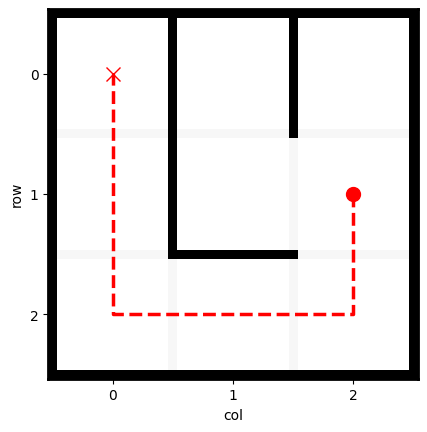

In [17]:
pd.set_option("display.max_colwidth", None)
mz: SolvedMaze = dataset[0]
MazePlot(mz).plot()
plt.show()

In [18]:
def all_elements_df(
	elem_type: type[_TokenizerElement],
	encoding: bool = True,
	**to_tokens_kwargs,
) -> pd.DataFrame:
	columns = ["_TokenizerElement", "tokens"]
	if encoding:
		columns.append("encoding")
	tokenizers: pd.DataFrame = pd.DataFrame(columns=columns)

	tokenizers["_TokenizerElement"] = list(
		all_instances(
			elem_type,
			validation_funcs=MAZE_TOKENIZER_MODULAR_DEFAULT_VALIDATION_FUNCS,
		),
	)
	tokenizers["tokens"] = tokenizers["_TokenizerElement"].apply(
		lambda x: " ".join(x.to_tokens(**to_tokens_kwargs)),
	)
	if encoding:
		tokenizers["encoding"] = tokenizers["tokens"].apply(
			lambda x: MazeTokenizerModular.encode(x),
		)
	return tokenizers

## `CoordTokenizers`

In [19]:
coord_tokenizers = all_elements_df(
	CoordTokenizers._CoordTokenizer,
	coord=mz.solution[0],
)
coord_tokenizers

,_TokenizerElement,tokens,encoding
0,UT(),"(1,2)",[1602]
1,"CTT(pre=T, intra=T, post=T)","( 1 , 2 )","[11, 321, 12, 322, 13]"
2,"CTT(pre=T, intra=T, post=F)","( 1 , 2","[11, 321, 12, 322]"
3,"CTT(pre=T, intra=F, post=T)",( 1 2 ),"[11, 321, 322, 13]"
4,"CTT(pre=T, intra=F, post=F)",( 1 2,"[11, 321, 322]"
5,"CTT(pre=F, intra=T, post=T)","1 , 2 )","[321, 12, 322, 13]"
6,"CTT(pre=F, intra=T, post=F)","1 , 2","[321, 12, 322]"
7,"CTT(pre=F, intra=F, post=T)",1 2 ),"[321, 322, 13]"
8,"CTT(pre=F, intra=F, post=F)",1 2,"[321, 322]"


## Adjacency List Tokenizers

In [20]:
adjlist_tokenizers = all_elements_df(
	AdjListTokenizers._AdjListTokenizer,
	encoding=False,
	maze=mz,
	coord_tokenizer=CoordTokenizers.UT(),
)
adjlist_tokenizers

,_TokenizerElement,tokens
0,"AdjListCoord(pre=F, post=T, shuffle_d0=T, Ungrouped(connection_token_ordinal=0), AllLatticeEdges(), SortedCoords())","<XX> (0,0) (0,1) ; <--> (1,1) (1,2) ; <--> (1,0) (2,0) ; <--> (1,2) (2,2) ; <--> (2,1) (2,2) ; <--> (0,1) (1,1) ; <XX> (1,0) (1,1) ; <XX> (0,1) (0,2) ; <--> (0,2) (1,2) ; <--> (2,0) (2,1) ; <--> (0,0) (1,0) ; <XX> (1,1) (2,1) ;"
1,"AdjListCoord(pre=F, post=T, shuffle_d0=T, Ungrouped(connection_token_ordinal=0), AllLatticeEdges(), RandomCoords())","<--> (2,0) (1,0) ; <XX> (1,0) (1,1) ; <--> (1,0) (0,0) ; <XX> (1,1) (2,1) ; <XX> (0,2) (0,1) ; <--> (2,1) (2,0) ; <--> (1,2) (0,2) ; <--> (2,2) (1,2) ; <--> (0,1) (1,1) ; <--> (1,1) (1,2) ; <--> (2,1) (2,2) ; <XX> (0,0) (0,1) ;"
2,"AdjListCoord(pre=F, post=T, shuffle_d0=T, Ungrouped(connection_token_ordinal=0), AllLatticeEdges(), BothCoords())","<--> (2,0) (2,1) ; <--> (1,0) (0,0) ; <XX> (0,1) (0,0) ; <XX> (2,1) (1,1) ; <--> (2,1) (2,0) ; <--> (1,2) (1,1) ; <--> (0,1) (1,1) ; <--> (2,0) (1,0) ; <XX> (0,2) (0,1) ; <--> (0,2) (1,2) ; <--> (0,0) (1,0) ; <XX> (1,1) (2,1) ; <XX> (0,0) (0,1) ; <--> (2,1) (2,2) ; <XX> (0,1) (0,2) ; <--> (2,2) (2,1) ; <--> (1,0) (2,0) ; <XX> (1,0) (1,1) ; <--> (1,1) (1,2) ; <--> (2,2) (1,2) ; <XX> (1,1) (1,0) ; <--> (1,2) (0,2) ; <--> (1,1) (0,1) ; <--> (1,2) (2,2) ;"
3,"AdjListCoord(pre=F, post=T, shuffle_d0=T, Ungrouped(connection_token_ordinal=0), ConnectionEdges(walls=T), SortedCoords())","<XX> (0,0) (0,1) ; <XX> (1,0) (1,1) ; <XX> (0,1) (0,2) ; <XX> (1,1) (2,1) ;"
4,"AdjListCoord(pre=F, post=T, shuffle_d0=T, Ungrouped(connection_token_ordinal=0), ConnectionEdges(walls=T), RandomCoords())","<XX> (0,2) (0,1) ; <XX> (2,1) (1,1) ; <XX> (1,0) (1,1) ; <XX> (0,1) (0,0) ;"
...,...,...
211,"AdjListCardinal(pre=F, post=F, shuffle_d0=F, Ungrouped(connection_token_ordinal=2), ConnectionEdges(walls=T), RandomCoords())","(1,1) SOUTH <XX> (0,0) EAST <XX> (0,1) EAST <XX> (1,1) WEST <XX>"
212,"AdjListCardinal(pre=F, post=F, shuffle_d0=F, Ungrouped(connection_token_ordinal=2), ConnectionEdges(walls=T), BothCoords())","(1,1) SOUTH <XX> (0,0) EAST <XX> (0,1) EAST <XX> (1,0) EAST <XX> (2,1) NORTH <XX> (0,1) WEST <XX> (0,2) WEST <XX> (1,1) WEST <XX>"
213,"AdjListCardinal(pre=F, post=F, shuffle_d0=F, Ungrouped(connection_token_ordinal=2), ConnectionEdges(walls=F), SortedCoords())","(0,0) SOUTH <--> (0,1) SOUTH <--> (0,2) SOUTH <--> (1,0) SOUTH <--> (1,1) EAST <--> (1,2) SOUTH <--> (2,0) EAST <--> (2,1) EAST <-->"
214,"AdjListCardinal(pre=F, post=F, shuffle_d0=F, Ungrouped(connection_token_ordinal=2), ConnectionEdges(walls=F), RandomCoords())","(1,0) NORTH <--> (1,1) NORTH <--> (0,2) SOUTH <--> (2,0) NORTH <--> (1,2) SOUTH <--> (1,1) EAST <--> (2,1) WEST <--> (2,2) WEST <-->"


## Target Tokenizers

In [21]:
target_tokenizers = all_elements_df(
	TargetTokenizers._TargetTokenizer,
	targets=[mz.end_pos],
	coord_tokenizer=CoordTokenizers.UT(),
)
target_tokenizers

,_TokenizerElement,tokens,encoding
0,Unlabeled(post=T),"(0,0) ||","[1596, 15]"
1,Unlabeled(post=F),"(0,0)",[1596]


## Path Tokenizers

In [22]:
path_tokenizers = all_elements_df(
	PathTokenizers._PathTokenizer,
	maze=mz,
	coord_tokenizer=CoordTokenizers.UT(),
)
path_tokenizers

,_TokenizerElement,tokens,encoding
0,"StepSequence(Singles(), step_tokenizers=(Coord(), ), pre=T, intra=T, post=T)","STEP (1,2) : STEP (2,2) : THEN STEP (2,1) : THEN STEP (2,0) : THEN STEP (1,0) : THEN STEP (0,0) : THEN","[704, 1602, 16, 704, 1604, 16, 17, 704, 1603, 16, 17, 704, 1601, 16, 17, 704, 1598, 16, 17, 704, 1596, 16, 17]"
1,"StepSequence(Singles(), step_tokenizers=(Coord(), ), pre=T, intra=T, post=F)","STEP (1,2) : STEP (2,2) : STEP (2,1) : STEP (2,0) : STEP (1,0) : STEP (0,0) :","[704, 1602, 16, 704, 1604, 16, 704, 1603, 16, 704, 1601, 16, 704, 1598, 16, 704, 1596, 16]"
2,"StepSequence(Singles(), step_tokenizers=(Coord(), ), pre=T, intra=F, post=T)","STEP (1,2) STEP (2,2) THEN STEP (2,1) THEN STEP (2,0) THEN STEP (1,0) THEN STEP (0,0) THEN","[704, 1602, 704, 1604, 17, 704, 1603, 17, 704, 1601, 17, 704, 1598, 17, 704, 1596, 17]"
3,"StepSequence(Singles(), step_tokenizers=(Coord(), ), pre=T, intra=F, post=F)","STEP (1,2) STEP (2,2) STEP (2,1) STEP (2,0) STEP (1,0) STEP (0,0)","[704, 1602, 704, 1604, 704, 1603, 704, 1601, 704, 1598, 704, 1596]"
4,"StepSequence(Singles(), step_tokenizers=(Coord(), ), pre=F, intra=T, post=T)","(1,2) : (2,2) : THEN (2,1) : THEN (2,0) : THEN (1,0) : THEN (0,0) : THEN","[1602, 16, 1604, 16, 17, 1603, 16, 17, 1601, 16, 17, 1598, 16, 17, 1596, 16, 17]"
...,...,...,...
1003,"StepSequence(Forks(), step_tokenizers=(Distance(), Relative(), Cardinal(), Coord(), ), pre=T, intra=F, post=F)","STEP (1,2) STEP +5 BACKWARD SOUTH (0,0)","[704, 1602, 704, 69, 60, 56, 1596]"
1004,"StepSequence(Forks(), step_tokenizers=(Distance(), Relative(), Cardinal(), Coord(), ), pre=F, intra=T, post=T)","(1,2) : +5 : BACKWARD : SOUTH : (0,0) : THEN","[1602, 16, 69, 16, 60, 16, 56, 16, 1596, 16, 17]"
1005,"StepSequence(Forks(), step_tokenizers=(Distance(), Relative(), Cardinal(), Coord(), ), pre=F, intra=T, post=F)","(1,2) : +5 : BACKWARD : SOUTH : (0,0) :","[1602, 16, 69, 16, 60, 16, 56, 16, 1596, 16]"
1006,"StepSequence(Forks(), step_tokenizers=(Distance(), Relative(), Cardinal(), Coord(), ), pre=F, intra=F, post=T)","(1,2) +5 BACKWARD SOUTH (0,0) THEN","[1602, 69, 60, 56, 1596, 17]"


## Prompt Sequencers

Currently, the only difference in possible prompt sequencers is the inclusion/exclusion of target tokens.

In [23]:
prompt_sequencers = [PromptSequencers.AOTP(), PromptSequencers.AOP()]
columns = ["_TokenizerElement", "tokens"]
tokenizers: pd.DataFrame = pd.DataFrame(columns=columns)

tokenizers["_TokenizerElement"] = prompt_sequencers
tokenizers["tokens"] = tokenizers["_TokenizerElement"].apply(
	lambda x: " ".join(x.to_tokens(maze=mz)),
)
tokenizers

,_TokenizerElement,tokens
0,"AOTP(UT(), AdjListCoord(pre=F, post=T, shuffle_d0=T, Ungrouped(connection_token_ordinal=1), ConnectionEdges(walls=F), RandomCoords()), Unlabeled(post=F), StepSequence(Singles(), step_tokenizers=(Coord(), ), pre=F, intra=F, post=F))","<ADJLIST_START> (0,1) <--> (1,1) ; (2,1) <--> (2,0) ; (2,2) <--> (1,2) ; (2,2) <--> (2,1) ; (0,2) <--> (1,2) ; (0,0) <--> (1,0) ; (1,1) <--> (1,2) ; (1,0) <--> (2,0) ; <ADJLIST_END> <ORIGIN_START> (1,2) <ORIGIN_END> <TARGET_START> (0,0) <TARGET_END> <PATH_START> (1,2) (2,2) (2,1) (2,0) (1,0) (0,0) <PATH_END>"
1,"AOP(UT(), AdjListCoord(pre=F, post=T, shuffle_d0=T, Ungrouped(connection_token_ordinal=1), ConnectionEdges(walls=F), RandomCoords()), StepSequence(Singles(), step_tokenizers=(Coord(), ), pre=F, intra=F, post=F))","<ADJLIST_START> (1,0) <--> (2,0) ; (0,1) <--> (1,1) ; (1,0) <--> (0,0) ; (2,1) <--> (2,2) ; (1,2) <--> (2,2) ; (2,1) <--> (2,0) ; (1,2) <--> (0,2) ; (1,1) <--> (1,2) ; <ADJLIST_END> <ORIGIN_START> (1,2) <ORIGIN_END> <TARGET_START> <TARGET_END> <PATH_START> (1,2) (2,2) (2,1) (2,0) (1,0) (0,0) <PATH_END>"


## Random Sample of `MazeTokenizerModular`s

In [24]:
random_sample_size: int = 1_000

tokenizers: list[MazeTokenizerModular] = random.sample(
	get_all_tokenizers(),
	random_sample_size,
)
columns = ["MazeTokenizerModular", "tokens", "encoding", *mt_default.summary().keys()]
df: pd.DataFrame = pd.DataFrame(columns=columns)

df["MazeTokenizerModular"] = tokenizers
df["tokens"] = df["MazeTokenizerModular"].apply(
	lambda x: " ".join(x.to_tokens(maze=mz)),
)
df.encoding = df.tokens.apply(MazeTokenizerModular.encode)

In [25]:
for k in tqdm(
	mt_default.summary().keys(),
	desc="Tokenizers",
	total=len(mt_default.summary()),
):
	df[k] = df.apply(
		lambda x: x.MazeTokenizerModular.summary().get(k, None),  # noqa: B023
		axis=1,
	)

pd.set_option("display.max_colwidth", 50)

df

Tokenizers: 100%|██████████| 10/10 [00:00<00:00, 25.21it/s]


,MazeTokenizerModular,tokens,encoding,prompt_sequencer,coord_tokenizer,adj_list_tokenizer,edge_grouping,edge_subset,edge_permuter,target_tokenizer,path_tokenizer,step_size,step_tokenizers
0,MazeTokenizerModular(prompt_sequencer=PromptSe...,<ADJLIST_START> 1 2 <--> 2 2 ; 2 0 <--> 2 1 ; ...,"[0, 321, 322, 8, 322, 322, 9, 322, 320, 8, 322...","AOP(CTT(pre=F, intra=F, post=F), AdjListCoord(...","CTT(pre=F, intra=F, post=F)","AdjListCoord(pre=F, post=T, shuffle_d0=T, Ungr...",Ungrouped(connection_token_ordinal=1),ConnectionEdges(walls=F),SortedCoords(),None,"StepSequence(Forks(), step_tokenizers=(Cardina...",Forks(),Cardinal()
1,MazeTokenizerModular(prompt_sequencer=PromptSe...,<ADJLIST_START> <XX> ( 1 1 ) ( 1 0 ) ; <--> ( ...,"[0, 707, 11, 321, 321, 13, 11, 321, 320, 13, 9...","AOP(CTT(pre=T, intra=F, post=T), AdjListCoord(...","CTT(pre=T, intra=F, post=T)","AdjListCoord(pre=F, post=T, shuffle_d0=T, Ungr...",Ungrouped(connection_token_ordinal=0),AllLatticeEdges(),BothCoords(),None,"StepSequence(Forks(), step_tokenizers=(Cardina...",Forks(),Relative()
2,MazeTokenizerModular(prompt_sequencer=PromptSe...,"<ADJLIST_START> ( 0 , 0 ) <XX> EAST ; ( 0 , 2 ...","[0, 11, 320, 12, 320, 13, 707, 57, 9, 11, 320,...","AOTP(CTT(pre=T, intra=T, post=T), AdjListCardi...","CTT(pre=T, intra=T, post=T)","AdjListCardinal(pre=F, post=T, shuffle_d0=F, U...",Ungrouped(connection_token_ordinal=1),AllLatticeEdges(),RandomCoords(),Unlabeled(post=F),"StepSequence(Forks(), step_tokenizers=(Coord()...",Forks(),Coord()
3,MazeTokenizerModular(prompt_sequencer=PromptSe...,<ADJLIST_START> <--> ( 1 1 EAST <XX> ( 0 0 EAS...,"[0, 8, 11, 321, 321, 57, 707, 11, 320, 320, 57...","AOP(CTT(pre=T, intra=F, post=F), AdjListCardin...","CTT(pre=T, intra=F, post=F)","AdjListCardinal(pre=F, post=F, shuffle_d0=T, U...",Ungrouped(connection_token_ordinal=0),AllLatticeEdges(),SortedCoords(),None,"StepSequence(Singles(), step_tokenizers=(Dista...",Singles(),Coord()
4,MazeTokenizerModular(prompt_sequencer=PromptSe...,<ADJLIST_START> <XX> 0 0 0 1 ; <--> 0 0 1 0 ; ...,"[0, 707, 320, 320, 320, 321, 9, 8, 320, 320, 3...","AOTP(CTT(pre=F, intra=F, post=F), AdjListCoord...","CTT(pre=F, intra=F, post=F)","AdjListCoord(pre=F, post=T, shuffle_d0=F, Ungr...",Ungrouped(connection_token_ordinal=0),AllLatticeEdges(),SortedCoords(),Unlabeled(post=F),"StepSequence(Singles(), step_tokenizers=(Relat...",Singles(),Coord()
...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,MazeTokenizerModular(prompt_sequencer=PromptSe...,<ADJLIST_START> <--> 1 0 ) SOUTH <XX> 1 1 ) SO...,"[0, 8, 321, 320, 13, 56, 707, 321, 321, 13, 56...","AOTP(CTT(pre=F, intra=F, post=T), AdjListCardi...","CTT(pre=F, intra=F, post=T)","AdjListCardinal(pre=F, post=F, shuffle_d0=T, U...",Ungrouped(connection_token_ordinal=0),AllLatticeEdges(),SortedCoords(),Unlabeled(post=F),"StepSequence(Forks(), step_tokenizers=(Cardina...",Forks(),Coord()
996,MazeTokenizerModular(prompt_sequencer=PromptSe...,"<ADJLIST_START> 1 , 0 ) 0 , 0 ) <--> ; 0 , 1 )...","[0, 321, 12, 320, 13, 320, 12, 320, 13, 8, 9, ...","AOTP(CTT(pre=F, intra=T, post=T), AdjListCoord...","CTT(pre=F, intra=T, post=T)","AdjListCoord(pre=F, post=T, shuffle_d0=F, Ungr...",Ungrouped(connection_token_ordinal=2),ConnectionEdges(walls=F),RandomCoords(),Unlabeled(post=F),"StepSequence(Forks(), step_tokenizers=(Coord()...",Forks(),Cardinal()
997,MazeTokenizerModular(prompt_sequencer=PromptSe...,"<ADJLIST_START> <--> ( 2 , 0 ) ( 2 , 1 ) <--> ...","[0, 8, 11, 322, 12, 320, 13, 11, 322, 12, 321,...","AOP(CTT(pre=T, intra=T, post=T), AdjListCoord(...","CTT(pre=T, intra=T, post=T)","AdjListCoord(pre=F, post=F, shuffle_d0=T, Ungr...",Ungrouped(connection_token_ordinal=0),ConnectionEdges(walls=F),SortedCoords(),None,"StepSequence(Forks(), step_tokenizers=(Relativ...",Forks(),Coord()
998,MazeTokenizerModular(prompt_sequencer=PromptSe...,"<ADJLIST_START> ( 2 , 0 <--> NORTH ( 2 , 2 <--...","[0, 11, 322, 12, 320, 8, 55, 11, 322, 12, 322,...","AOP(CTT(pre=T, intra=T, post=F), AdjListCardi